## Training

In [1]:
import sys
!pip install mlxtend

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.evaluate import PredefinedHoldoutSplit

### Process Data

In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
OXFORD_DATA_FILE = 'data/OxCGRT_latest.csv'
SOCIAL_EXPLORER_DATA_FILE = '../../../../../data/social_explorer_data.csv'
LODES_DATA_FILE = '../../../../../data/lodes_us_states_rac_S000_JT00_2018.csv'

In [4]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, OXFORD_DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x1dc375db070>)

In [5]:
# Load historical data from local file
oxford_data = pd.read_csv(OXFORD_DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [6]:
oxford_data.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [7]:
def transform_data(data):
    # pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
    pipe = make_pipeline(StandardScaler(with_std=True))
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data, pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1))
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1))
    return pipe.inverse_transform(data)

# Load Census Data

In [8]:
census_data = pd.read_csv(SOCIAL_EXPLORER_DATA_FILE, skiprows=[1])
census_data.drop(columns=['FIPS'], inplace=True)
cols = census_data.columns.values
for feat in cols:
    if 'Employed' in feat or 'Unemployed' in feat:
        census_data.drop(columns=[feat], inplace=True)
    
print(census_data.shape)
# Standardize Census data
census_columns = census_data.columns[1:]
census_regions = census_data['Qualifying Name']
census_data, census_pipe = transform_data(census_data.iloc[:, 1:].values)
census_data = pd.DataFrame(data=census_data,columns=census_columns)
census_data.insert(0, 'Qualifying Name', census_regions)
census_data

(54, 67)


,Qualifying Name,Population Density (Per Sq. Mile),Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,...,Two or More Races Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level,Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,Hispanic or Latino Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level,"White Alone, Not Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level","White Alone, Not Hispanic or Latino Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level",Average Commute to Work (In Min),Total: No Health Insurance Coverage,Total: with Health Insurance Coverage,Total: with Health Insurance Coverage: Public Health Coverage,Total: with Health Insurance Coverage: Private Health Insurance
0,Alabama,-0.209714,-0.166327,-0.165787,-0.166604,-0.163750,-0.165746,-0.171345,-0.168694,-0.165292,...,-0.215377,-0.233454,-0.244737,-0.129053,-0.158779,0.103873,-0.154960,-0.166478,-0.160808,-0.166013
1,Alaska,-0.272031,-0.256160,-0.256843,-0.258793,-0.259192,-0.258948,-0.256370,-0.259290,-0.260415,...,-0.230400,-0.265129,-0.259492,-0.265343,-0.260173,-1.056642,-0.248670,-0.260856,-0.261099,-0.260787
2,Arizona,-0.232181,-0.113621,-0.110950,-0.109680,-0.112443,-0.111925,-0.117736,-0.119993,-0.127608,...,-0.096877,-0.002694,-0.012225,-0.125412,-0.131026,0.297293,-0.085921,-0.118884,-0.100917,-0.126837
3,Arkansas,-0.235064,-0.205094,-0.204002,-0.206366,-0.205847,-0.208030,-0.211696,-0.209747,-0.211075,...,-0.223286,-0.236091,-0.241587,-0.162112,-0.199023,-0.476384,-0.208794,-0.208160,-0.193112,-0.214974
4,California,-0.107519,0.641720,0.629098,0.632856,0.620052,0.636612,0.702458,0.661517,0.619051,...,1.108147,1.250163,1.595589,0.250022,0.283757,1.070969,0.483483,0.632618,0.685039,0.569377
5,Colorado,-0.237363,-0.151035,-0.146641,-0.148784,-0.151366,-0.150144,-0.133056,-0.138473,-0.151099,...,-0.127808,-0.158813,-0.117739,-0.159048,-0.129105,0.297293,-0.164585,-0.147316,-0.160081,-0.143247
6,Connecticut,0.211443,-0.207276,-0.203589,-0.198064,-0.193669,-0.192449,-0.203512,-0.199610,-0.187097,...,-0.192875,-0.197774,-0.200571,-0.222317,-0.183497,0.490712,-0.225083,-0.191890,-0.195390,-0.190447
7,Delaware,0.049419,-0.255564,-0.256489,-0.254933,-0.255789,-0.256020,-0.255010,-0.256190,-0.254525,...,-0.256360,-0.257632,-0.256048,-0.259565,-0.254561,0.297293,-0.259897,-0.253935,-0.252877,-0.253492
8,Washington DC,7.160315,-0.259229,-0.263646,-0.265966,-0.267054,-0.258334,-0.249394,-0.257684,-0.262973,...,-0.258806,-0.263205,-0.256574,-0.272117,-0.268038,1.264389,-0.267371,-0.259782,-0.260379,-0.260241
9,Florida,-0.017277,0.146294,0.139085,0.146624,0.148788,0.146069,0.169477,0.178716,0.204939,...,0.122046,0.265462,0.385415,0.170631,0.150529,0.684131,0.411304,0.178467,0.220517,0.164438


# Load LODES Data

In [9]:
lodes_data = pd.read_csv(LODES_DATA_FILE, skiprows=[1])
print(lodes_data.shape)

# Standardize lodes data
lodes_columns = lodes_data.columns[1:]
lodes_regions = lodes_data['Qualifying Name']
lodes_data, lodes_pipe = transform_data(lodes_data.iloc[:, 1:].values)
lodes_data = pd.DataFrame(data=lodes_data,columns=lodes_columns)
lodes_data.insert(0, 'Qualifying Name', lodes_regions)
lodes_data

(54, 42)


,Qualifying Name,Total number of jobs,Number of jobs for workers age 29 or younger,Number of jobs for workers age 30 to 54,Number of jobs for workers age 55 or older,Number of jobs with earnings $1250/month or less,Number of jobs with earnings $1251/month to $3333/month,Number of jobs with earnings greater than $3333/month,"Number of jobs in NAICS sector 11 (Agriculture, Forestry, Fishing and Hunting)","Number of jobs in NAICS sector 21 (Mining, Quarrying, and Oil and Gas Extraction)",...,Number of jobs for workers with Race: Native Hawaiian or Other Pacific Islander Alone,Number of jobs for workers with Race: Two or More Race Groups,Number of jobs for workers with Ethnicity: Not Hispanic or Latino,Number of jobs for workers with Ethnicity: Hispanic or Latino,Number of jobs for workers with Educational Attainment: Less than high school,"Number of jobs for workers with Educational Attainment: High school or equivalent, no college",Number of jobs for workers with Educational Attainment: Some college or Associate degree,Number of jobs for workers with Educational Attainment: Bachelor's degree or advanced degree,Number of jobs for workers with Sex: Male,Number of jobs for workers with Sex: Female
0,Alabama,-0.174117,-0.169695,-0.173588,-0.179662,-0.168464,-0.161996,-0.185213,-0.192479,-0.193650,...,-0.235297,-0.220009,-0.160331,-0.243794,-0.179834,-0.161175,-0.170489,-0.191486,-0.173988,-0.174243
1,Alaska,-0.276185,-0.276287,-0.276071,-0.276311,-0.276418,-0.276260,-0.275939,-0.265843,-0.262116,...,-0.265116,-0.273535,-0.277112,-0.265284,-0.273764,-0.276875,-0.276390,-0.275861,-0.276092,-0.276273
2,Arizona,-0.130479,-0.130149,-0.128744,-0.134754,-0.138133,-0.110658,-0.140592,-0.096733,-0.124573,...,-0.084752,-0.102907,-0.154851,0.002165,-0.096423,-0.135261,-0.123965,-0.149310,-0.126280,-0.134684
3,Arkansas,-0.214080,-0.210860,-0.214045,-0.217305,-0.210996,-0.199510,-0.225643,-0.190969,-0.210606,...,-0.208831,-0.229026,-0.208493,-0.239217,-0.214049,-0.205229,-0.212836,-0.226501,-0.214689,-0.213466
4,California,0.608740,0.571163,0.634249,0.587369,0.549870,0.582190,0.655200,1.953800,-0.054961,...,1.682283,1.129399,0.410252,1.652892,0.948698,0.428080,0.577992,0.685357,0.628602,0.588819
5,Colorado,-0.139624,-0.138449,-0.137382,-0.145888,-0.147947,-0.145551,-0.131473,-0.154053,0.044481,...,-0.155756,-0.117030,-0.143887,-0.113900,-0.149877,-0.148598,-0.139292,-0.127917,-0.134984,-0.144271
6,Connecticut,-0.188674,-0.195024,-0.191242,-0.176525,-0.195389,-0.205138,-0.173934,-0.239006,-0.255264,...,-0.223503,-0.200614,-0.187091,-0.193031,-0.201443,-0.196197,-0.191932,-0.165296,-0.191404,-0.185933
7,Delaware,-0.253758,-0.254116,-0.254067,-0.252668,-0.253044,-0.254839,-0.253271,-0.250734,-0.260883,...,-0.258125,-0.254285,-0.252611,-0.254391,-0.254116,-0.253857,-0.254151,-0.252239,-0.254579,-0.252931
8,Washington DC,-0.259932,-0.257578,-0.259146,-0.264013,-0.265037,-0.264372,-0.254319,-0.265885,-0.262127,...,-0.257673,-0.253548,-0.259691,-0.255601,-0.257659,-0.263728,-0.263808,-0.255293,-0.260824,-0.259032
9,Florida,0.172270,0.153372,0.172468,0.190416,0.187054,0.255020,0.107488,0.177770,-0.209122,...,-0.022832,0.106452,0.127635,0.406310,0.265564,0.180682,0.179552,0.132103,0.170473,0.174068


In [10]:
# For testing, restrict training data to that before a hypothetical predictor submission date
SUBMISSION_DATE = np.datetime64("2020-11-30")
oxford_data = oxford_data[oxford_data.Date <= SUBMISSION_DATE]

# Remove current day and previous day because data may be incomplete
# oxford_data = oxford_data.groupby("GeoID", as_index=False).apply(lambda x: x.iloc[:-2])

In [11]:
cols = oxford_data.columns
for col in cols:
    if 'Index' in col or 'Flag' in col or 'Wildcard' in col:
        oxford_data.drop(columns=col, inplace=True)

for idx, row in oxford_data[oxford_data['Date'] == '2020-01-01'].iterrows():
    for elem in row[6:].items():
        if (elem[1] == 0.0):
            continue
        if (np.isnan(elem[1])):
            oxford_data.loc[idx, elem[0]] = 0
        
oxford_data['GeoID'] = oxford_data['CountryName'] + '__' + oxford_data['RegionName'].astype(str)
oxford_data['ConfirmedCases'].fillna(0, inplace=True)
oxford_data['ConfirmedDeaths'].fillna(0, inplace=True)
oxford_data['E3_Fiscal measures'].fillna(0, inplace=True)
oxford_data['E4_International support'].fillna(0, inplace=True)
oxford_data['H4_Emergency investment in healthcare'].fillna(0, inplace=True)
oxford_data['H5_Investment in vaccines'].fillna(0, inplace=True)

def log_data(series):
    df = np.log(series)
    df.replace(-np.inf, 0, inplace=True)
    return df
# Transform non categorical features by taking the natural log
oxford_data['E3_Fiscal measures'] = log_data(oxford_data['E3_Fiscal measures'])
oxford_data['E4_International support'] = log_data(oxford_data['E4_International support'])
oxford_data['H4_Emergency investment in healthcare'] = log_data(oxford_data['H4_Emergency investment in healthcare'])
oxford_data['H5_Investment in vaccines'] = log_data(oxford_data['H5_Investment in vaccines'])

new_oxford = []
# Forward fill for each specific region to handle nan for categorical features
for geoid in oxford_data['GeoID'].unique():
    region_df = oxford_data[oxford_data['GeoID'] == geoid]
    for col in region_df.columns[4:].values:
        region_df[col] = region_df[col].ffill()
    new_oxford.append(region_df)
oxford_data = pd.concat(new_oxford)

oxford_data['NewCases'] = oxford_data.groupby('GeoID').ConfirmedCases.diff().fillna(0)
oxford_data['NewDeaths'] = oxford_data.groupby('GeoID').ConfirmedDeaths.diff().fillna(0)
oxford_data.drop(columns=['Jurisdiction', 'RegionCode'], inplace=True)
oxford_data.drop(columns=['CountryCode'], inplace=True)
# Compute the 7 day moving average
oxford_data["7DMA"] = oxford_data.groupby(
    "GeoID")['NewCases'].rolling(7, center=False).mean().reset_index(0, drop=True)
oxford_data["7DMA"]= oxford_data["7DMA"].fillna(0)


# move column to be earlier
geoid = oxford_data['GeoID']
oxford_data.drop(labels=['GeoID'], axis = 1, inplace = True)
oxford_data.insert(3, 'GeoID', geoid)

oxford_data.drop(columns=['ConfirmedCases', 'ConfirmedDeaths', 'NewDeaths'], inplace=True)
oxford_data.head()

c:\users\kaush\onedrive\desktop\usc classes\cs499\usc-xprize-covid\xprize\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\kaush\onedrive\desktop\usc classes\cs499\usc-xprize-covid\xprize\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-11-6d845d58ccda>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df[col] = region_df[col].ffill()


,CountryName,RegionName,Date,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,...,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,NewCases,7DMA
0,Aruba,NaN,2020-01-01,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,2020-01-02,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,2020-01-03,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,2020-01-04,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,2020-01-05,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases', '7DMA']
npi_cols_categorical = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

# To be used later
census_cols = list(census_data.columns[1:].values)
lodes_cols = list(lodes_data.columns[1:].values)

In [13]:
npi_cols = []

for col in npi_cols_categorical:
  one_hot = pd.get_dummies(oxford_data[col],prefix=col)
  for new_col in one_hot.columns.values:
    npi_cols.append(new_col)
  oxford_data = oxford_data.drop(col, axis=1)
  oxford_data = oxford_data.join(one_hot)
npi_cols

['C1_School closing_0.0',
 'C1_School closing_1.0',
 'C1_School closing_2.0',
 'C1_School closing_3.0',
 'C2_Workplace closing_0.0',
 'C2_Workplace closing_1.0',
 'C2_Workplace closing_2.0',
 'C2_Workplace closing_3.0',
 'C3_Cancel public events_0.0',
 'C3_Cancel public events_1.0',
 'C3_Cancel public events_2.0',
 'C4_Restrictions on gatherings_0.0',
 'C4_Restrictions on gatherings_1.0',
 'C4_Restrictions on gatherings_2.0',
 'C4_Restrictions on gatherings_3.0',
 'C4_Restrictions on gatherings_4.0',
 'C5_Close public transport_0.0',
 'C5_Close public transport_1.0',
 'C5_Close public transport_2.0',
 'C6_Stay at home requirements_0.0',
 'C6_Stay at home requirements_1.0',
 'C6_Stay at home requirements_2.0',
 'C6_Stay at home requirements_3.0',
 'C7_Restrictions on internal movement_0.0',
 'C7_Restrictions on internal movement_1.0',
 'C7_Restrictions on internal movement_2.0',
 'C8_International travel controls_0.0',
 'C8_International travel controls_1.0',
 'C8_International travel c

In [14]:
oxford_data = oxford_data[id_cols + npi_cols + cases_col]

oxford_data = oxford_data.sort_values(by=['Date', 'GeoID'])
# Move columns around
date_col = oxford_data.pop('Date')
oxford_data.insert(0, 'Date', date_col)
# cases_col = oxford_data.pop('NewCases')
# oxford_data.insert(4, 'NewCases', cases_col)

oxford_data = oxford_data.reset_index(drop=True)
oxford_data

# california_df = oxford_data[oxford_data['RegionName'] == 'California']
# plt.bar(california_df['Date'], california_df['NewCases'])

# texas_df = oxford_data[oxford_data['RegionName'] == 'Texas']
# plt.bar(texas_df['Date'], texas_df['NewCases'])

,Date,CountryName,RegionName,GeoID,C1_School closing_0.0,C1_School closing_1.0,C1_School closing_2.0,C1_School closing_3.0,C2_Workplace closing_0.0,C2_Workplace closing_1.0,...,H3_Contact tracing_0.0,H3_Contact tracing_1.0,H3_Contact tracing_2.0,H6_Facial Coverings_0.0,H6_Facial Coverings_1.0,H6_Facial Coverings_2.0,H6_Facial Coverings_3.0,H6_Facial Coverings_4.0,NewCases,7DMA
0,2020-01-01,Afghanistan,NaN,Afghanistan__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
1,2020-01-01,Albania,NaN,Albania__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
2,2020-01-01,Algeria,NaN,Algeria__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
3,2020-01-01,Andorra,NaN,Andorra__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
4,2020-01-01,Angola,NaN,Angola__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,2020-11-30,Venezuela,NaN,Venezuela__nan,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,354.0,321.571429
93796,2020-11-30,Vietnam,NaN,Vietnam__nan,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,4.0,5.000000
93797,2020-11-30,Yemen,NaN,Yemen__nan,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,14.0,12.000000
93798,2020-11-30,Zambia,NaN,Zambia__nan,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,39.0,27.571429


In [15]:
# Remove non USA regions for now. Comment out below line if we want every country.
oxford_data = oxford_data[(oxford_data['CountryName'] == 'United States') & (oxford_data['RegionName'].notnull())]
print(oxford_data['RegionName'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'Washington DC'
 'West Virginia' 'Wisconsin' 'Wyoming']


In [16]:
oxford_data

,Date,CountryName,RegionName,GeoID,C1_School closing_0.0,C1_School closing_1.0,C1_School closing_2.0,C1_School closing_3.0,C2_Workplace closing_0.0,C2_Workplace closing_1.0,...,H3_Contact tracing_0.0,H3_Contact tracing_1.0,H3_Contact tracing_2.0,H6_Facial Coverings_0.0,H6_Facial Coverings_1.0,H6_Facial Coverings_2.0,H6_Facial Coverings_3.0,H6_Facial Coverings_4.0,NewCases,7DMA
219,2020-01-01,United States,Alabama,United States__Alabama,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
220,2020-01-01,United States,Alaska,United States__Alaska,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
221,2020-01-01,United States,Arizona,United States__Arizona,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
222,2020-01-01,United States,Arkansas,United States__Arkansas,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
223,2020-01-01,United States,California,United States__California,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93786,2020-11-30,United States,Washington,United States__Washington,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,2462.0,2456.000000
93787,2020-11-30,United States,Washington DC,United States__Washington DC,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,104.0,180.285714
93788,2020-11-30,United States,West Virginia,United States__West Virginia,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,845.0,961.142857
93789,2020-11-30,United States,Wisconsin,United States__Wisconsin,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,2676.0,4576.714286


<AxesSubplot:>

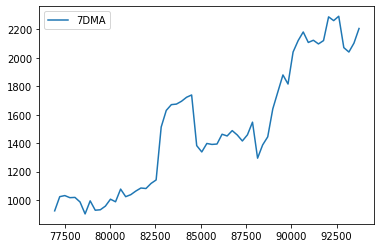

In [17]:
oxford_data[(oxford_data['GeoID']=='United States__Alabama') & (oxford_data.Date>='2020-10-01')][['7DMA']].plot()

<AxesSubplot:>

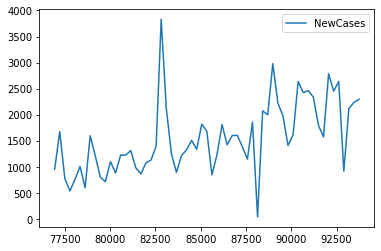

In [18]:
oxford_data[(oxford_data['GeoID']=='United States__Alabama') & (oxford_data.Date>='2020-10-01')][['NewCases']].plot()

### Model Training

In [19]:
def process_data(df, nb_lookback_days, nb_lookback_months, test_months, static, rolling, ff_index):   
    cases_col_used = ['7DMA'] if rolling else ['NewCases']
    # Create training data across all regions for predicting one day ahead
    if static:
      df = add_static_data(df)
      X_cols = cases_col_used + npi_cols + census_cols + lodes_cols
    else:
      X_cols = cases_col_used + npi_cols      
    y_cols = ['GeoID', 'Date'] + cases_col_used # Include GeoID and date to create graphs
    
    X_samples = []
    y_samples = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    train_date = SUBMISSION_DATE-np.timedelta64((nb_lookback_months+test_months)*30, 'D')
    geo_ids = df.GeoID.unique()
    for g in geo_ids:
        gdf = df[(df.GeoID == g) & (df.Date >= train_date)]
        all_case_data = np.array(gdf[cases_col_used])
        all_npi_data = np.array(gdf[npi_cols])
        
        if static:
          all_census_data = np.array(gdf[census_cols].iloc[0])
          all_lodes_data = np.array(gdf[lodes_cols].iloc[0])
        
        all_bookkeeping_data = np.array(gdf[y_cols])

        # Create one sample for each day where we have enough data
        # Each sample consists of cases and npis for previous nb_lookback_days
        nb_total_days = len(gdf)
        
        for d in range(nb_lookback_days, nb_total_days - 1):
            X_cases = all_case_data[d-nb_lookback_days:d]
            X_npis = all_npi_data[d - nb_lookback_days:d]
            X_npis_or = np.bitwise_or.reduce(X_npis, axis=0)
            
            # Flatten all input data
            if static:
              X_census = all_census_data
              X_lodes = all_lodes_data
              X_sample = np.concatenate([X_cases.flatten(),
                                         X_npis_or.flatten(),
                                         X_census.flatten(), X_lodes.flatten()])
              if len(ff_index) != 0:
                    X_sample = X_sample[:, np.array[ff_index]]
            else:
               X_sample = np.concatenate([X_cases.flatten(),X_npis_or.flatten()])              
            y_sample = all_bookkeeping_data[d]
            
            if d < nb_total_days-test_months*30:
                X_train.append(X_sample)
                y_train.append(y_sample)
            else:
                X_test.append(X_sample)
                y_test.append(y_sample)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)[:,-1]
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [20]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))
def add_static_data(df):
  for col in census_cols:
    df[col] = 0
  for idx, census_row in census_data.iterrows():
    for num, feat in enumerate(census_cols):
      df[feat] = np.where(df['RegionName'] == census_row[0], census_row[num + 1] , df[feat])

  for col in lodes_cols:
    df[col] = 0
  for idx, lodes_row in lodes_data.iterrows():
    for num, feat in enumerate(lodes_cols):
      df[feat] = np.where(df['RegionName'] == lodes_row[0], lodes_row[num + 1] , df[feat])    

  return df


In [21]:
def f_selection(df, nb_lookback_days, nb_lookback_months, test_months, model):
    df_copy = df.copy()
     # Create training data across all regions for predicting one day ahead
    df = add_static_data(df)
    X_cols = cases_col + npi_cols + census_cols + lodes_cols 
    y_cols = ['NewCases'] # Include GeoID and date to create graphs
    
    # Column indices for fixed features to be always considered in feature selection
    ff_index = tuple(range(nb_lookback_days*(len(cases_col)+len(npi_cols))))

    X_samples = []
    y_samples = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    train_date = SUBMISSION_DATE-np.timedelta64((nb_lookback_months+test_months)*30, 'D')
    geo_ids = df.GeoID.unique()
    for g in geo_ids:
        gdf = df[(df.GeoID == g) & (df.Date >= train_date)]
        all_case_data = np.array(gdf[cases_col])
        all_npi_data = np.array(gdf[npi_cols])        
        all_census_data = np.array(gdf[census_cols])
        all_lodes_data = np.array(gdf[lodes_cols])
        all_bookkeeping_data = np.array(gdf[y_cols])

        # Create one sample for each day where we have enough data
        # Each sample consists of cases and npis for previous nb_lookback_days
        nb_total_days = len(gdf)
        
        for d in range(nb_lookback_days, nb_total_days - 1):
            X_cases = all_case_data[d-nb_lookback_days:d]
            X_npis = all_npi_data[d - nb_lookback_days:d]

            # Flatten all input data
            X_census = all_census_data
            X_lodes = all_lodes_data
            X_sample = np.concatenate([X_cases.flatten(),
                                     X_npis.flatten(),
                                     X_census.flatten(), X_lodes.flatten()])            
            y_sample = all_bookkeeping_data[d]
            
            if d < nb_total_days-test_months*30:
                X_train.append(X_sample)
                y_train.append(y_sample)
            else:
                X_test.append(X_sample)
                y_test.append(y_sample)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)[:,-1]
    y_test = np.array(y_test)
    
    fs_X = np.vstack((X_train,X_test))
    fs_y = np.hstack((y_train, y_test[:,-1]))
    fs_cv_in = np.array(list(range(X_train.shape[0]-1,fs_X.shape[0])))
    piter = PredefinedHoldoutSplit(fs_cv_in)
    sfs1 = sfs(model,
            k_features='parsimonious',
            forward=True,
            floating=False,
            verbose=0,
            scoring='neg_mean_absolute_error',
            cv=piter,
            fixed_features=ff_index)

    # Perform SFFS
    sfs1 = sfs1.fit(fs_X, fs_y)
    return sfs1.subsets_

In [22]:
def run(df, nb_lookback_days, nb_lookback_months, test_months, model, inspect, graph, static, rolling, ff_index=[]):
    df_copy = df.copy()
    X_train, X_test, y_train, y_test = process_data(df_copy,
                                                    nb_lookback_days, 
                                                    nb_lookback_months,
                                                    test_months,
                                                    static,
                                                    rolling,
                                                    ff_index
                                                   )
    print("X_train: ", X_train.shape)
    print("X_test: ", X_test.shape)
    print("y_train: ", y_train.shape)
    print("y_test: ", y_test.shape)
    print('Preprocessing done!')
    model.fit(X_train, y_train)
    print('Training done!')
    # Evaluate model
    train_preds = model.predict(X_train)
    train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
    print('Train MAE:', mae(train_preds, y_train))
    test_preds = model.predict(X_test)
    test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
    print('Test MAE:', mae(test_preds, y_test[:,-1]))
    
    # Inspect the learned feature coefficients for the model
    # to see what features it's paying attention to.
    if inspect:
        # Give names to the features
        x_col_names = []
        for d in range(-nb_lookback_days, 0):
            x_col_names.append('Day ' + str(d) + ' ' + cases_col[0])
        for d in range(-nb_lookback_days, 1):
            for col_name in npi_cols:
                x_col_names.append('Day ' + str(d) + ' ' + col_name)

        # View non-zero coefficients
        for (col, coeff) in zip(x_col_names, list(model.coef_)):
            if coeff != 0.:
                print(col, coeff)
        print('Intercept', model.intercept_)
        
    if graph:
        graph_np = np.hstack((y_test, test_preds.reshape(-1,1)))
        geo_ids = np.unique(graph_np[:,0])
        for geo_id in geo_ids:
            gnp = graph_np[graph_np[:,0]==geo_id, :]
            plt.figure()
            plt.plot(gnp[:,1], gnp[:,3], label='Prediction')
            plt.plot(gnp[:,1], gnp[:,2], label='Actual')
            plt.title(geo_id)
            plt.legend()
            plt.show()
            
    return model


In [23]:
# f_sub = f_selection(oxford_data, 30, 20, 2, LinearRegression(), [])
# f_sub

In [24]:
# model = run(df=oxford_data, 
#             nb_lookback_days=30, 
#             nb_lookback_months=20, 
#             test_months=10, 
#             model=LinearRegression(), 
#             inspect=False, 
#             graph=False, 
#             static=False, 
#             rolling=False, 
#             ff_index=[])

In [25]:
# model = run(df=oxford_data, 
#             nb_lookback_days=30, 
#             nb_lookback_months=20, 
#             test_months=10, 
#             model=LinearRegression(), 
#             inspect=False, 
#             graph=False, 
#             static=False, 
#             rolling=True, 
#             ff_index=[])

In [26]:
# %%time
# model = run(oxford_data, 30, 20, 2, LinearRegression(), False, False, True)

In [27]:
# model = run(oxford_data, 30, 20, 2, SVR(), False, False, False)

In [28]:
# Takes more than a few minutes to fit.
# model = run(oxford_data, 30, 20, 2, SVR(), False, False, True)

In [29]:
# model = run(df=oxford_data, 
#             nb_lookback_days=30, 
#             nb_lookback_months=20, 
#             test_months=10, 
#             model=GradientBoostingRegressor(), 
#             inspect=False, 
#             graph=False, 
#             static=False, 
#             rolling=False, 
#             ff_index=[])


X_train:  (14300, 183)
X_test:  (1508, 183)
y_train:  (14300,)
y_test:  (1508, 3)
Preprocessing done!
Training done!
Train MAE: 135.2324515923208
Test MAE: 784.6160384903321


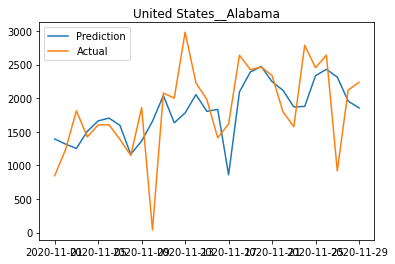

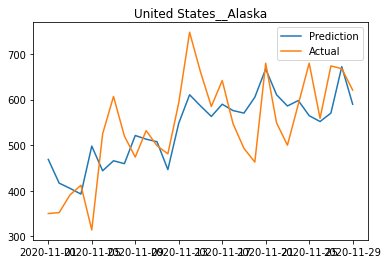

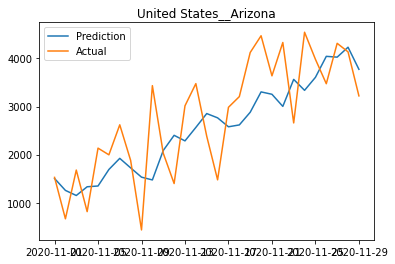

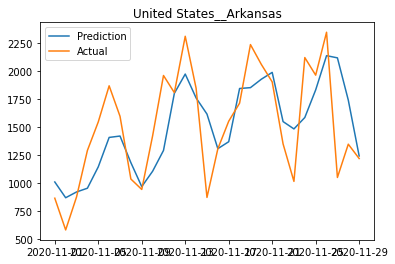

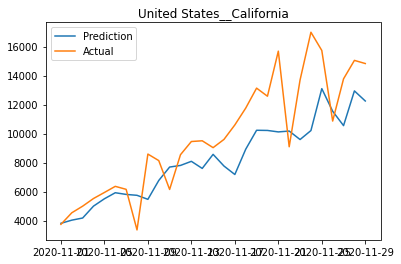

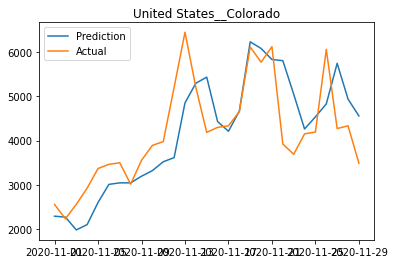

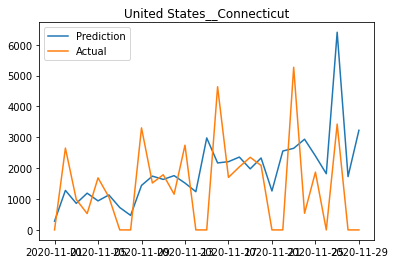

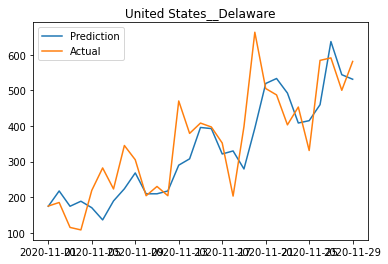

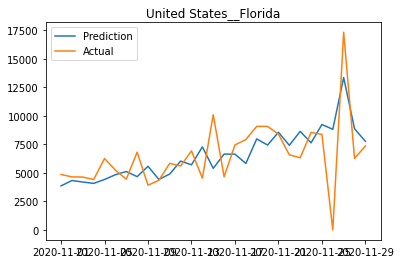

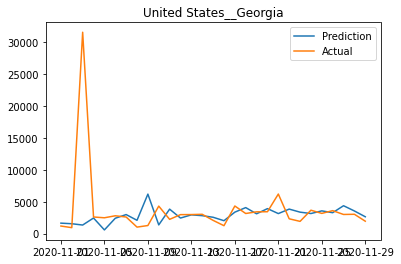

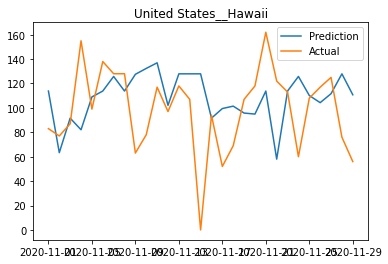

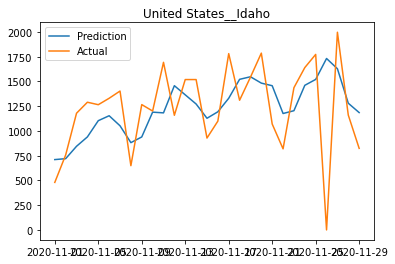

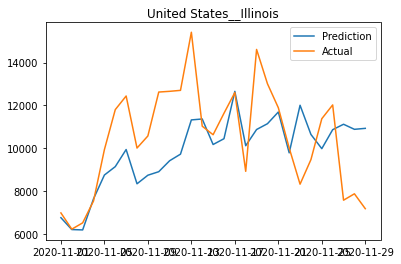

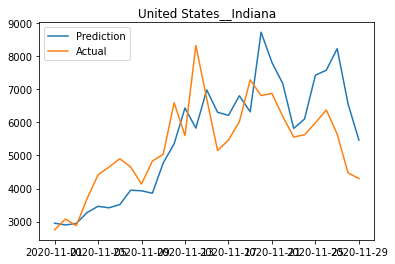

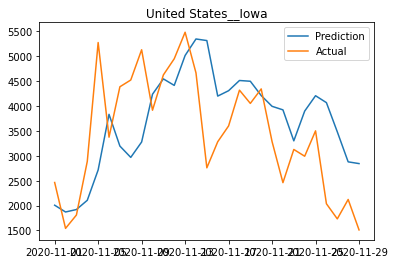

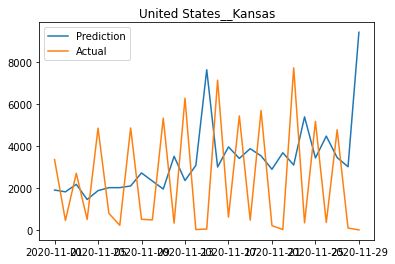

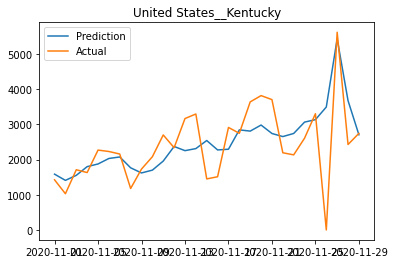

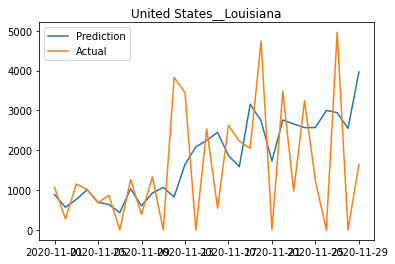

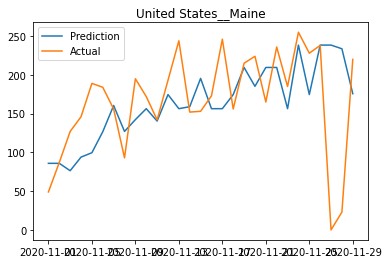

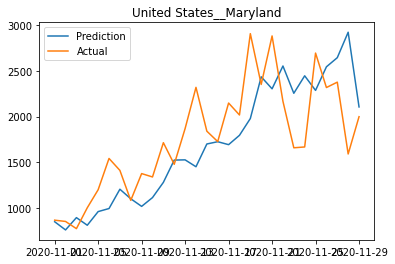

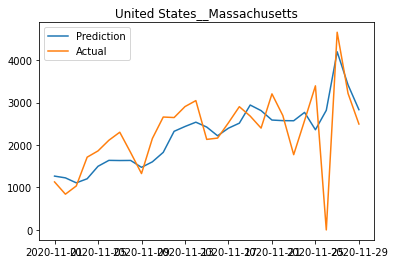

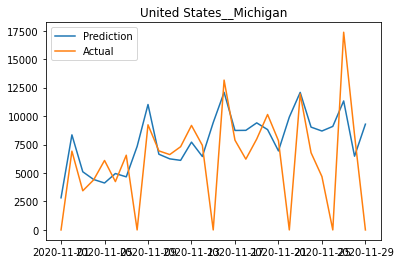

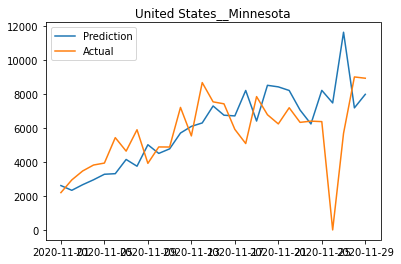

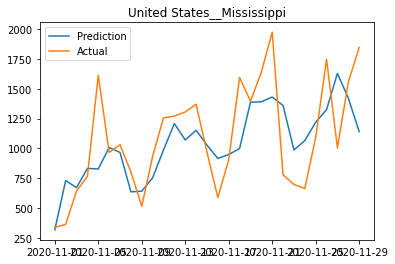

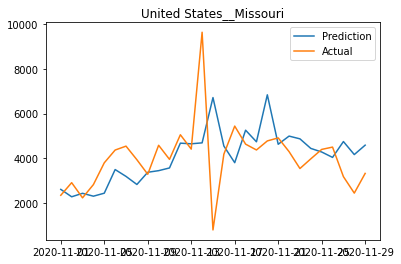

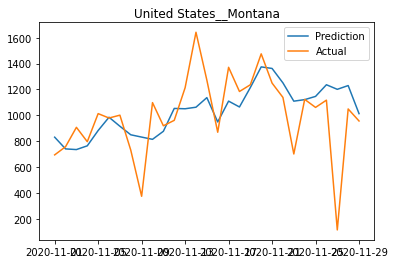

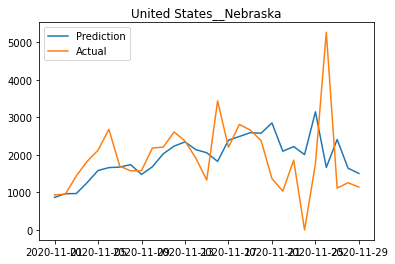

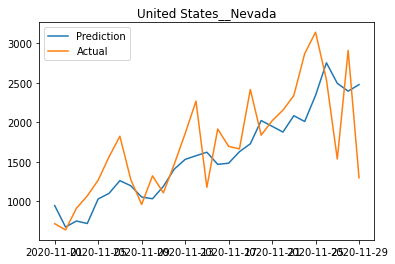

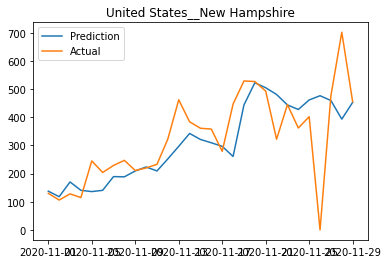

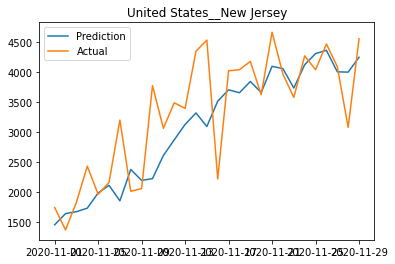

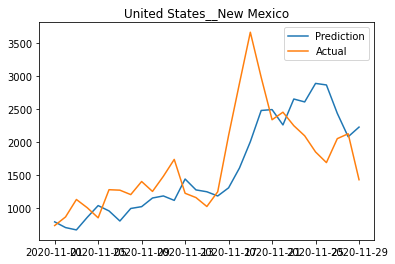

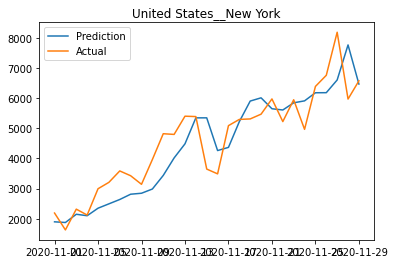

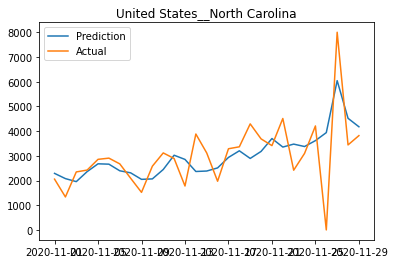

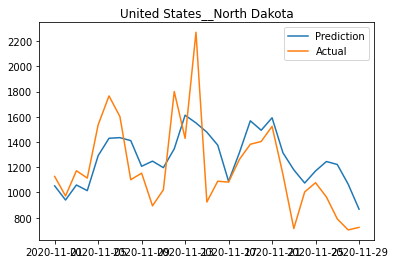

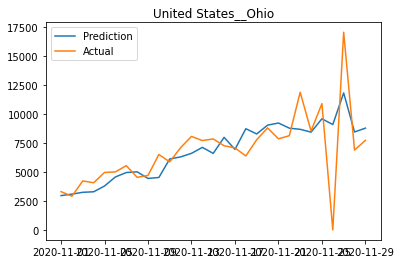

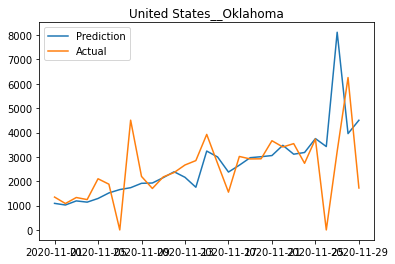

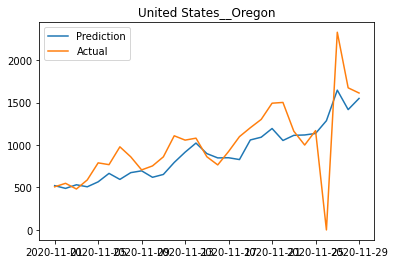

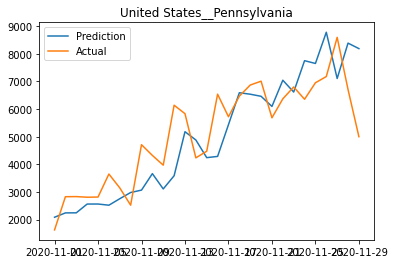

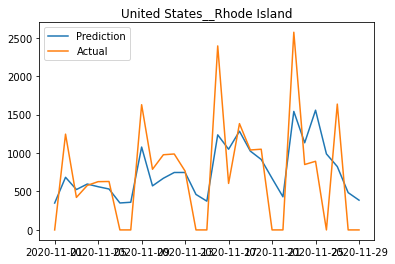

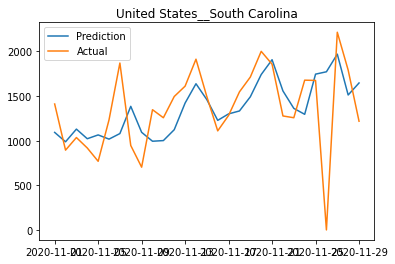

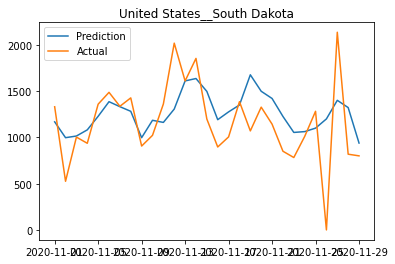

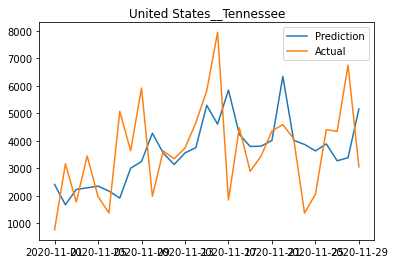

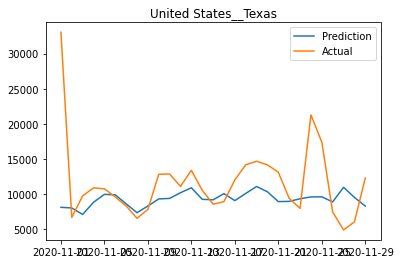

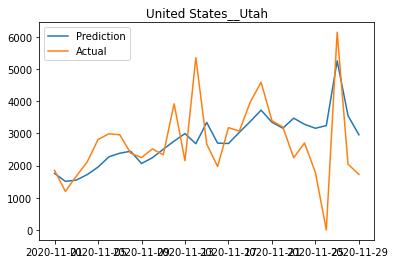

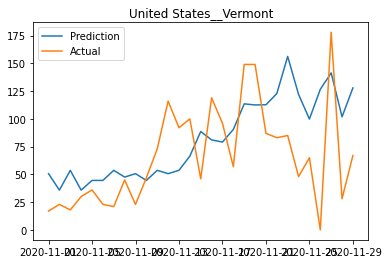

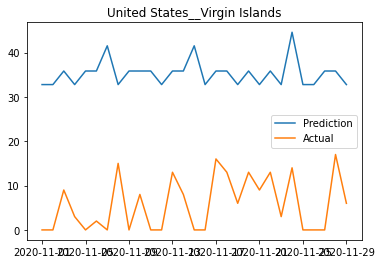

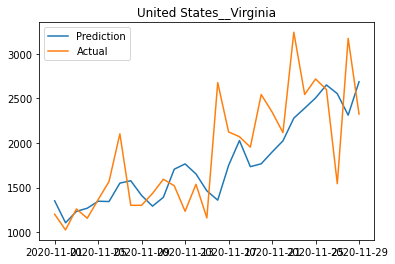

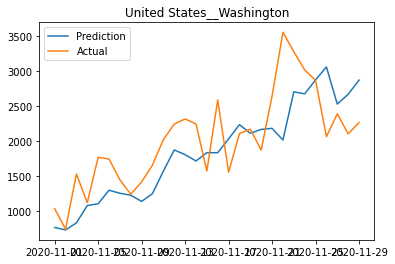

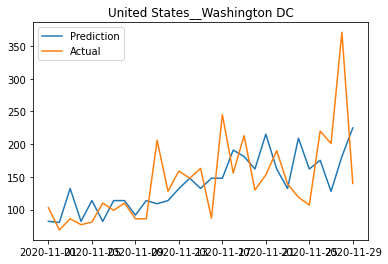

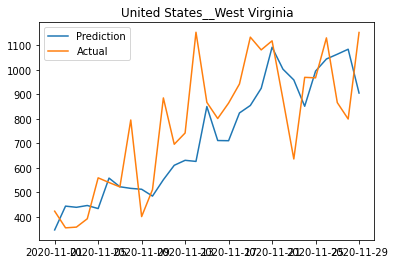

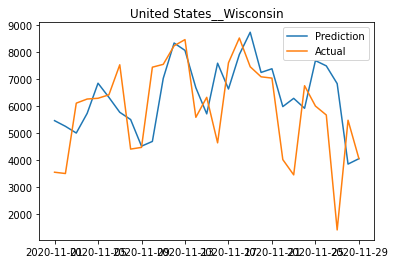

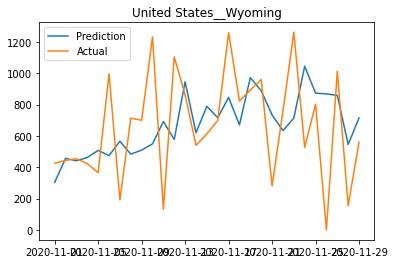

In [30]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=1, 
            model=GradientBoostingRegressor(), 
            inspect=False, 
            graph=True, 
            static=True, 
            rolling=False, 
            ff_index=[])


X_train:  (14300, 76)
X_test:  (1508, 76)
y_train:  (14300,)
y_test:  (1508, 3)
Preprocessing done!
Training done!
Train MAE: 23.535952960546773
Test MAE: 150.9162071545914


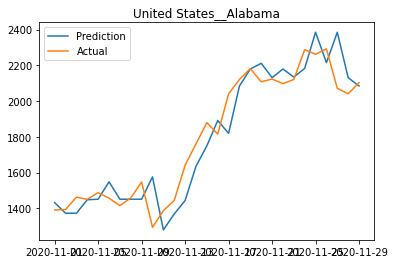

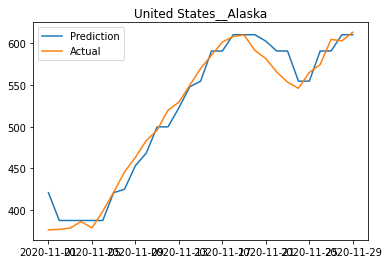

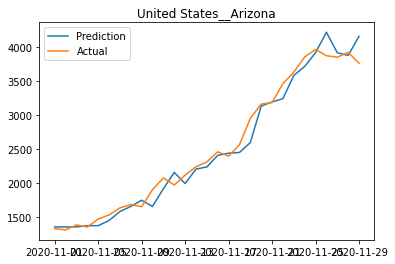

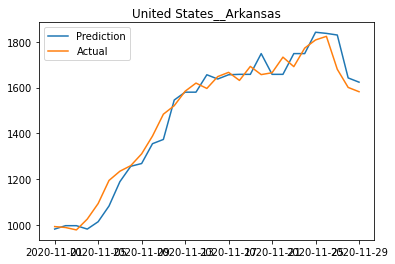

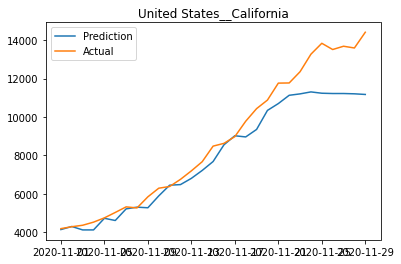

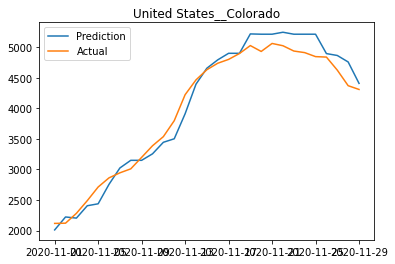

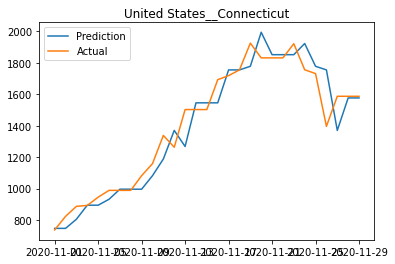

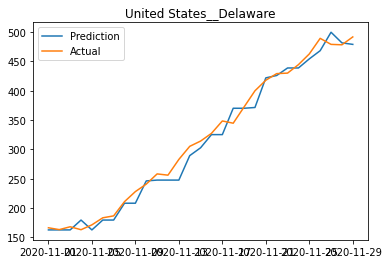

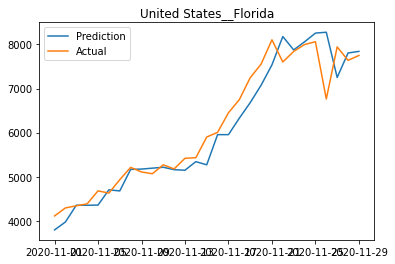

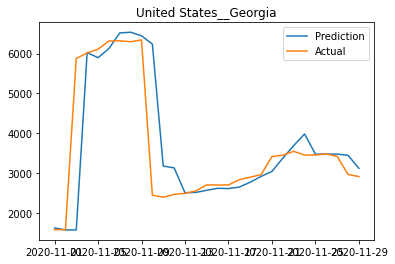

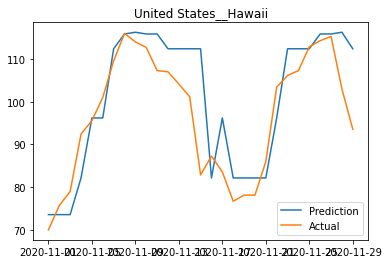

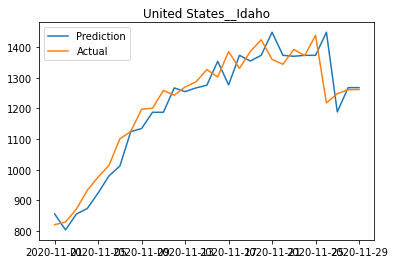

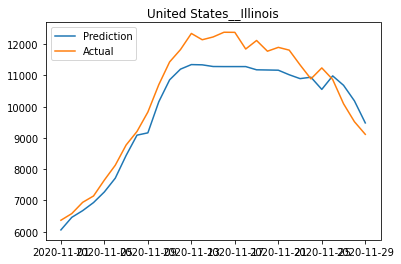

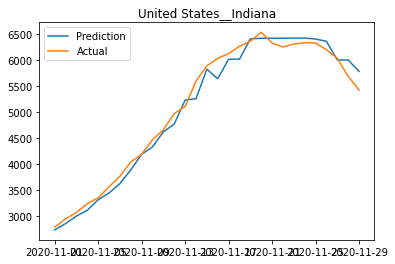

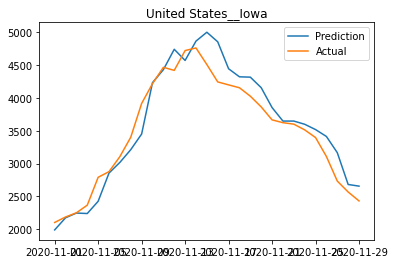

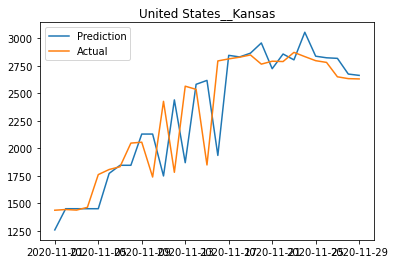

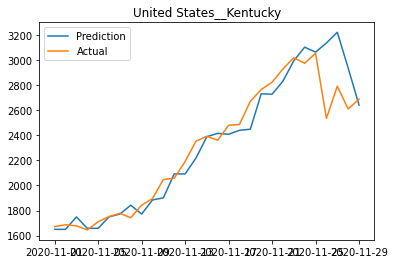

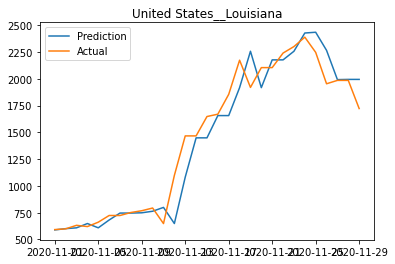

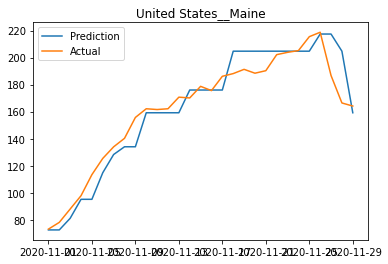

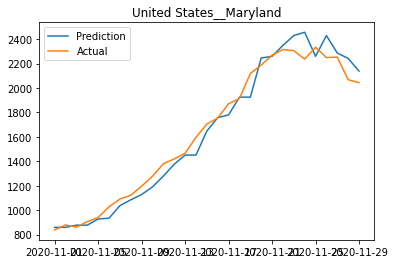

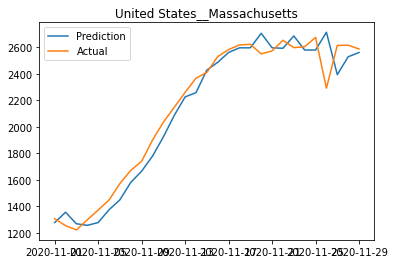

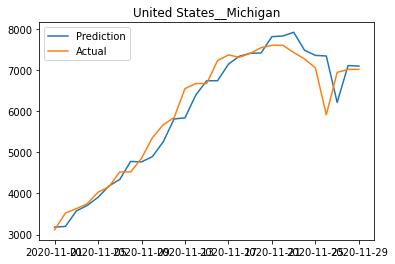

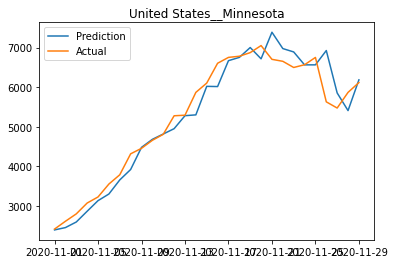

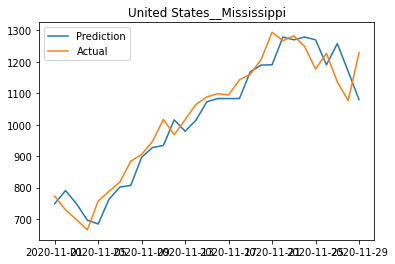

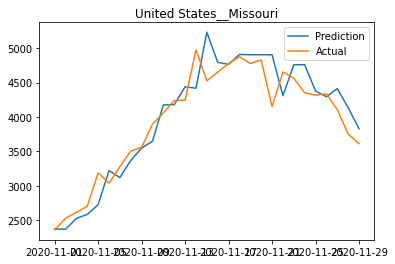

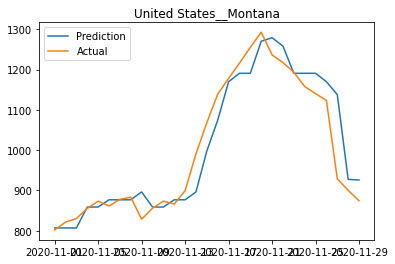

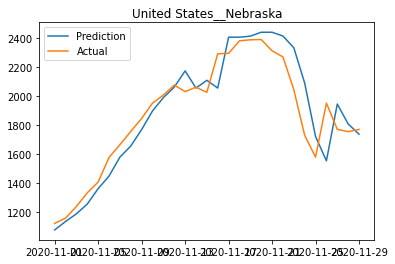

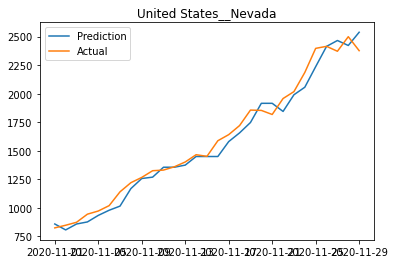

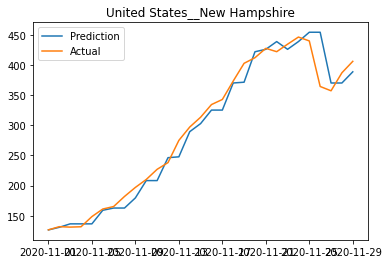

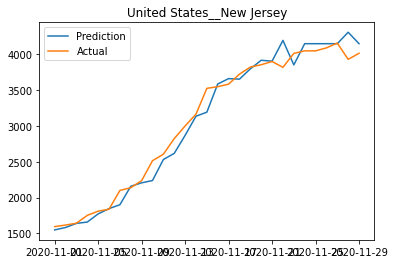

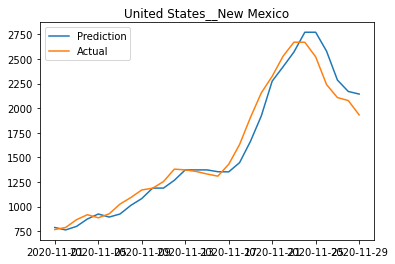

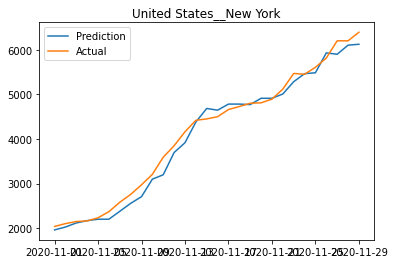

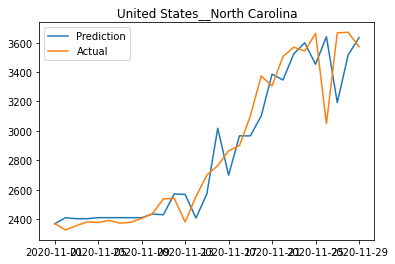

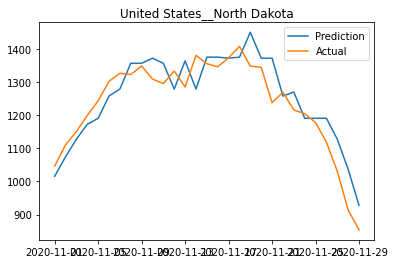

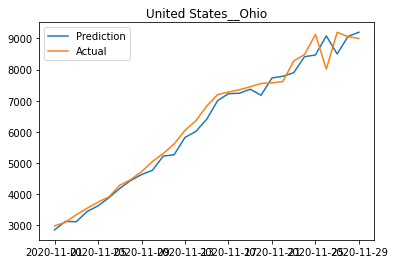

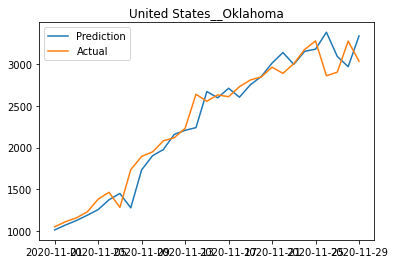

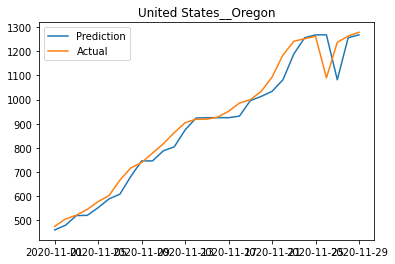

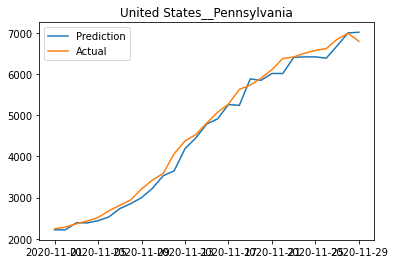

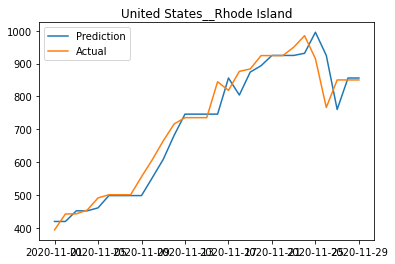

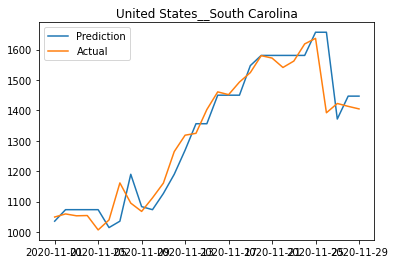

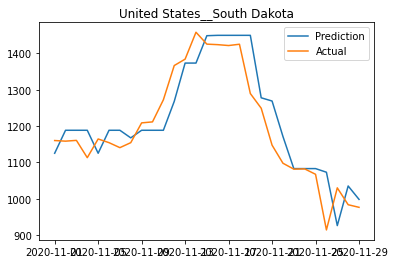

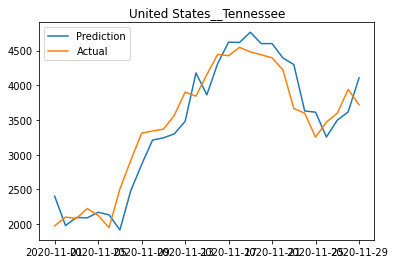

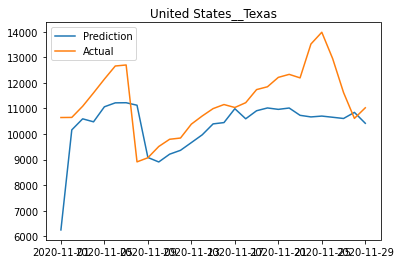

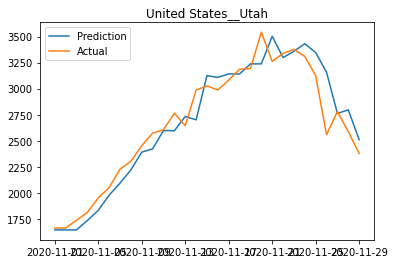

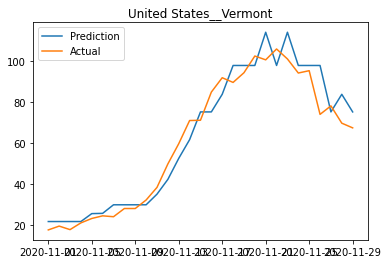

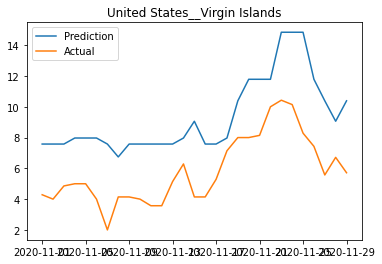

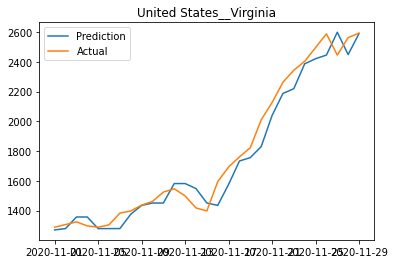

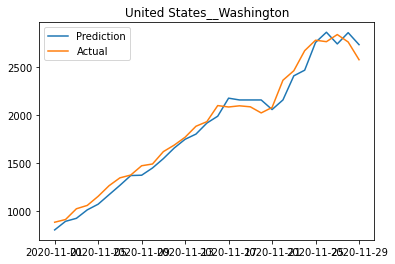

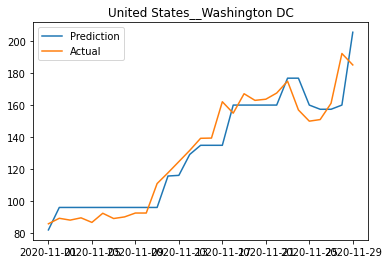

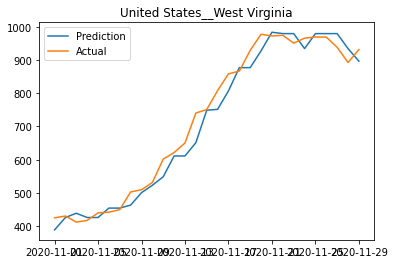

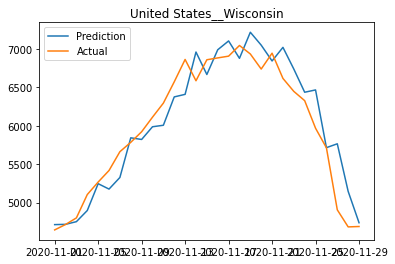

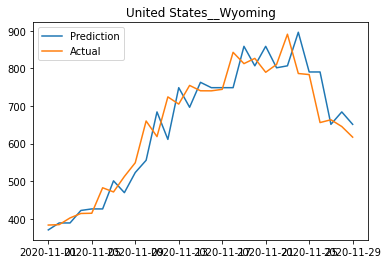

In [48]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=1, 
            model=GradientBoostingRegressor(), 
            inspect=False, 
            graph=True, 
            static=False, 
            rolling=True, 
            ff_index=[])

In [32]:
# Takes more than a few minutes to fit.
# model = run(oxford_data, 30, 20, 2, GradientBoostingRegressor(), False, False, True)

In [33]:
# model = run(oxford_data, 14, 20, 2, LinearRegression(), False, False, False)

In [34]:
# model = run(oxford_data, 14, 20, 2, LinearRegression(), False, False, True)

In [35]:
# model = run(oxford_data, 14, 5, 3, LinearRegression(), False, False, False)

In [36]:
# model = run(oxford_data, 14, 5, 3, LinearRegression(), False, False, True)

In [49]:
# Save model to file (this just stores whatever is the last uncommented model)
if not os.path.exists('models'):
    os.mkdir('models')
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data. Make changes in predict.py since that's what is called

In [51]:
%%time
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df
# doesnt work for non american regions rn because of different data sizes.. or 
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="../../../validation/data/2020-09-30_historical_ip.csv",
                      verbose=False, NB_LOOKBACK_DAYS=30, rolling=False, static=False)

Wall time: 5.46 s


In [39]:
# Check the predictions
preds_df[preds_df['CountryName']=='United States'].tail()

,CountryName,RegionName,Date,PredictedDailyNewCases
70109,United States,Wyoming,2020-08-27,122.037126
70110,United States,Wyoming,2020-08-28,140.587460
70111,United States,Wyoming,2020-08-29,140.587460
70112,United States,Wyoming,2020-08-30,140.587460
70113,United States,Wyoming,2020-08-31,140.587460


# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [40]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip ../../../validation/data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/2020-08-01_2020-08-04.csv
Done!


In [41]:
!head predictions/2020-08-01_2020-08-04.csv

CountryName,RegionName,Date,PredictedDailyNewCases
United States,,2020-08-01,10822.52689679078
United States,,2020-08-02,10979.357780241993
United States,,2020-08-03,12855.58127382358
United States,,2020-08-04,12437.213249698849
United States,Alaska,2020-08-01,116.33170865269197
United States,Alaska,2020-08-02,177.84448939008053
United States,Alaska,2020-08-03,116.33170865269197
United States,Alaska,2020-08-04,148.6404689215919
United States,Alabama,2020-08-01,1602.8263639134095


# Test cases
We can generate a prediction file. Let's validate a few cases...

In [42]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [43]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="../../../validation/data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/val_4_days.csv
Done!
Missing countries / regions: {'Kenya', 'Lithuania', 'Romania', 'Somalia', 'Brazil / Acre', 'Bosnia and Herzegovina', 'Uganda', 'Lesotho', 'Brazil / Mato Grosso do Sul', 'China', 'Chad', 'Algeria', 'Turkey', 'Bermuda', 'Oman', 'Ukraine', 'Democratic Republic of Congo', 'Brazil / Parana', 'Georgia', 'Russia', 'Niger', 'Indonesia', 'Brazil / Santa Catarina', 'Brazil / Pernambuco', 'Andorra', 'Brazil / Paraiba', 'Brazil / Maranhao', 'Belize', 'Mongolia', 'Belarus', 'Ethiopia', 'Kyrgyz Republic', 'Austria', 'Brazil / Bahia', 'Botswana', 'Panama', 'Israel', 'Taiwan', 'Italy', 'Pakistan', 'Tanzania', 'Bulgaria', 'Barbados', 'Puerto Rico', 'Moldova', 'Paraguay', 'United Kingdom / Northern Ireland', 'Djibouti', 'El Salvador', 'Brazil / Amazonas', 'Kosovo', 'Yemen', 'Congo', 'Cyprus', 'Iceland', 'Bahamas', 'Canada', 'Dominica', 'Fiji', 'Brazil / Rio Grande do Sul', 'Croatia', 'Dominican 

## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [44]:
%%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="../../../validation/data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

Generating predictions from 2021-01-01 to 2021-01-31...


Traceback (most recent call last):
  File "predict.py", line 330, in <module>
    predict(args.start_date, args.end_date, args.ip_file, args.output_file)
  File "predict.py", line 105, in predict
    preds_df = predict_df(start_date, end_date, path_to_ips_file, verbose=False, NB_LOOKBACK_DAYS=nb_lookback_days, rolling=rolling, static=static)
  File "predict.py", line 299, in predict_df
    pred_df = pd.concat(geo_pred_dfs)
  File "C:\Users\kaush\OneDrive\Desktop\USC Classes\cs499\usc-xprize-covid\xprize\lib\site-packages\pandas\core\reshape\concat.py", line 274, in concat
    op = _Concatenator(
  File "C:\Users\kaush\OneDrive\Desktop\USC Classes\cs499\usc-xprize-covid\xprize\lib\site-packages\pandas\core\reshape\concat.py", line 331, in __init__
    raise ValueError("No objects to concatenate")
ValueError: No objects to concatenate


FileNotFoundError: [Errno 2] No such file or directory: 'predictions/val_1_month_future.csv'

## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [45]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

Start date: 2020-12-25
End date: 2021-06-23


In [46]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

Saved scenario to predictions/180_days_future_scenario.csv


### Check it

In [47]:
%%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=scenario_file,
         output_file="predictions/val_6_month_future.csv")

Generating predictions from 2020-12-25 to 2021-06-23...
Saved predictions to predictions/val_6_month_future.csv
Done!
Missing countries / regions: {'Kenya', 'Lithuania', 'Romania', 'Somalia', 'Brazil / Acre', 'Bosnia and Herzegovina', 'Uganda', 'Lesotho', 'Brazil / Mato Grosso do Sul', 'China', 'Chad', 'Algeria', 'Turkey', 'Canada / Alberta', 'Bermuda', 'Oman', 'Ukraine', 'Democratic Republic of Congo', 'Brazil / Parana', 'Georgia', 'Russia', 'Niger', 'Indonesia', 'Malta', 'Brazil / Santa Catarina', 'Brazil / Pernambuco', 'Andorra', 'Brazil / Paraiba', 'Brazil / Maranhao', 'Belize', 'Canada / New Brunswick', 'Mongolia', 'Belarus', 'Ethiopia', 'Kyrgyz Republic', 'Austria', 'Brazil / Bahia', 'Canada / Newfoundland and Labrador', 'Botswana', 'Panama', 'Israel', 'Taiwan', 'Italy', 'Pakistan', 'Tanzania', 'Bulgaria', 'Barbados', 'Puerto Rico', 'Moldova', 'Paraguay', 'United Kingdom / Northern Ireland', 'Djibouti', 'El Salvador', 'Brazil / Amazonas', 'Kosovo', 'Yemen', 'Congo', 'Cyprus', 'Ic